Movie Recommendation System Project

A Movie Recommendation System is a machine learning-based application that suggests movies to users based on their preferences or behavior. These systems help users discover content from large catalogs efficiently.

There are generally three types of recommendation systems:

1. Content-Based Filtering – recommends movies similar to those a user liked in the past.
2. Collaborative Filtering – recommends movies based on the preferences of similar users.
3. Hybrid Systems – combine both approaches for better accuracy.

Importing Libraries

In [167]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

Dataset Loading and Collection

In this project, we will utilize the MovieLens dataset, a widely used benchmark dataset for building and evaluating recommendation systems.
MovieLens dataset includes:
1. movies.csv – contains movie titles and genres.
2. ratings.csv – includes user ratings for different movies.
3. tags.csv – user-defined tags for movies.
4. links.csv – links to external movie databases (IMDB, TMDB).

In [197]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

Displaying basic information about the dataset 

In [170]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [171]:
movies.info()
movies.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


(9742, 3)

In [172]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [173]:
links.info()
links.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


(9742, 3)

In [174]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [175]:
ratings.info()
ratings.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


(100836, 4)

In [176]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [177]:
tags.info()
tags.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


(3683, 4)

Data Preprocessing

Steps includes:
1. Handling missing values (e.g., NaN values in tags or ratings).
2. Removing duplicates.
3. Converting data types (e.g., timestamps to datetime).
4. Filtering users/movies based on activity thresholds (e.g., users with few ratings).

In [178]:
# Convert timestamp to datetime in ratings and tags for better readability
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

In [179]:
# Check for missing values
print("Missing values in movies:\n", movies.isnull().sum())
print("Missing values in ratings:\n", ratings.isnull().sum())
print("Missing values in tags:\n", tags.isnull().sum())
print("Missing values in links:\n", links.isnull().sum())

Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64
Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
Missing values in links:
 movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [180]:
# Merge links data with movies data to have no missing values 
links_cleaned = links.dropna(subset=['tmdbId'])
movies_merged = movies.merge(links_cleaned, on='movieId', how='inner')

In [181]:
# View merged data
movies_merged.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [182]:
# Drop duplicates if any
movies.drop_duplicates(inplace=True)
ratings.drop_duplicates(inplace=True)
tags.drop_duplicates(inplace=True)
links.drop_duplicates(inplace=True)

In [183]:
# Remove users and movies with very few ratings to reduce noise and sparsity.
# For example: keep only users with >=20 ratings and movies with >=50 ratings
active_users = ratings['userId'].value_counts()
popular_movies = ratings['movieId'].value_counts()

ratings_changed = ratings[ratings['userId'].isin(active_users[active_users >= 20].index)]
ratings_changed = ratings[ratings['movieId'].isin(popular_movies[popular_movies >= 50].index)]
ratings_changed.info()
ratings_changed.shape

<class 'pandas.core.frame.DataFrame'>
Index: 41360 entries, 0 to 100742
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     41360 non-null  int64         
 1   movieId    41360 non-null  int64         
 2   rating     41360 non-null  float64       
 3   timestamp  41360 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.6 MB


(41360, 4)

Exploratory Data Analysis(EDA)

Steps includes:
1. Count of movies and users.
2. Distribution of ratings.
3. Most rated and highest average-rated movies.
4. Common genres and their popularity.
5. Distribution of tags.
6. Temporal trends in rating activity.

In [184]:
# Set style
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

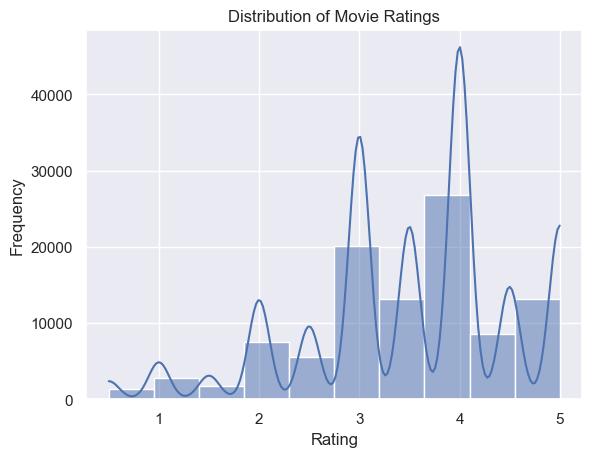

In [185]:
# Rating distribution
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

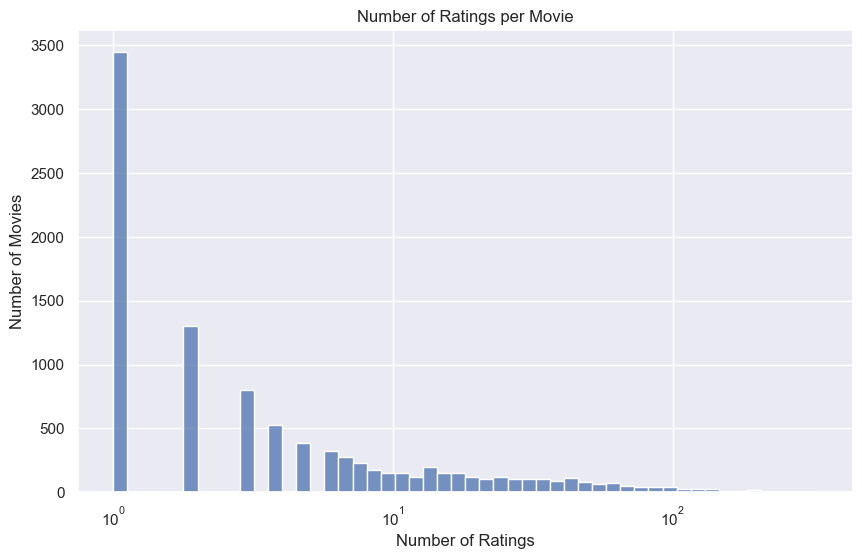

In [186]:
# Number of ratings per movie
rating_counts = ratings.groupby('movieId').size()
plt.figure(figsize=(10, 6))
sns.histplot(rating_counts, bins=50, log_scale=True)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

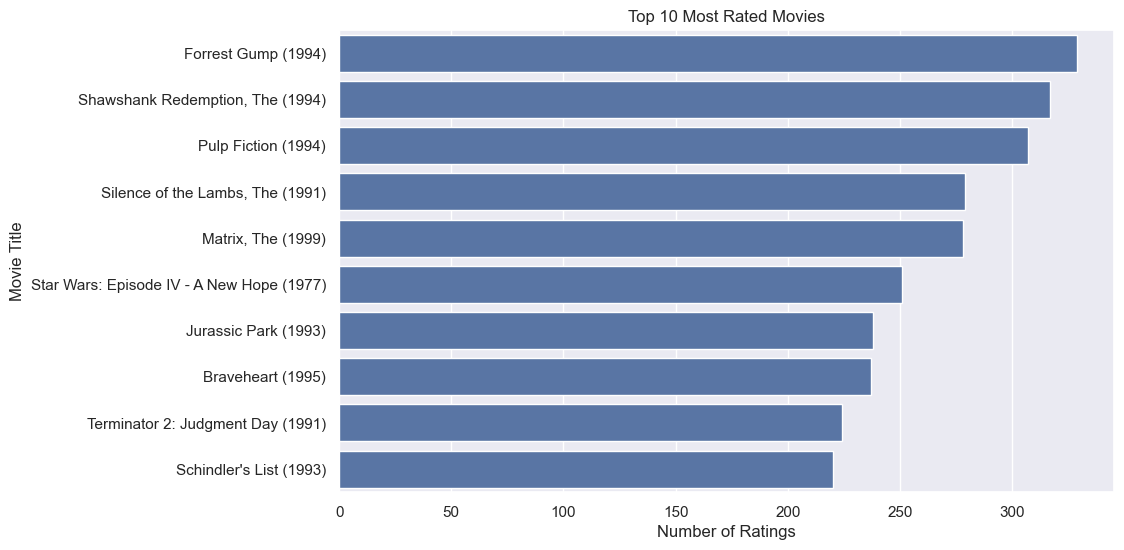

In [187]:
# Top 10 most rated movies
top_movies = ratings['movieId'].value_counts().head(10).index
top_movie_titles = movies[movies['movieId'].isin(top_movies)][['movieId', 'title']]
top_movie_counts = ratings[ratings['movieId'].isin(top_movies)]['movieId'].value_counts()
top_movie_titles = top_movie_titles.merge(top_movie_counts.rename('count'), on='movieId')

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='title', data=top_movie_titles.sort_values('count', ascending=False))
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


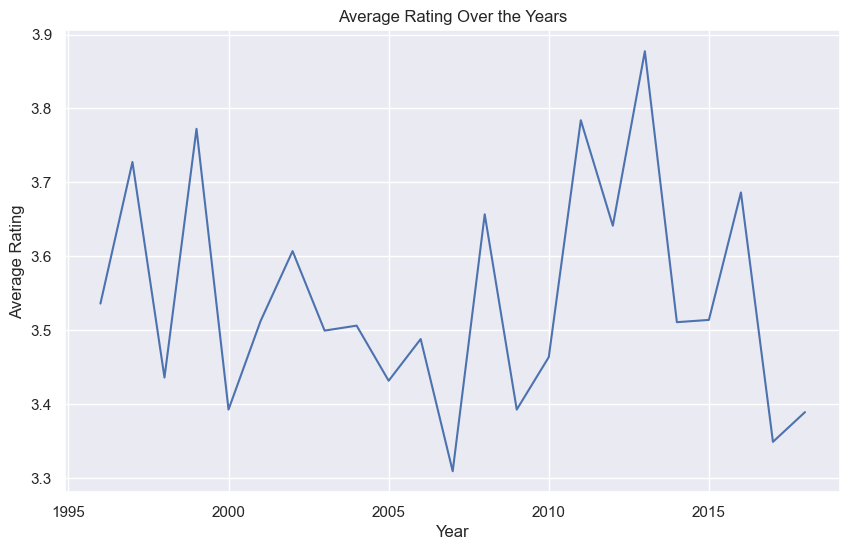

In [188]:
# Ratings over time
ratings['year'] = ratings['timestamp'].dt.year
yearly_ratings = ratings.groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='rating', data=yearly_ratings)
plt.title('Average Rating Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

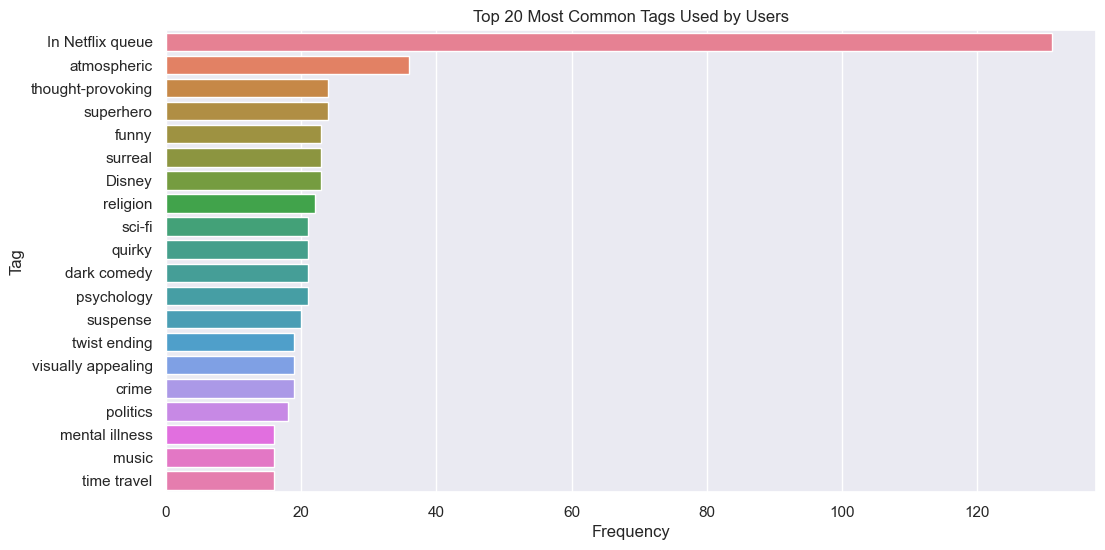

In [189]:
# Distribution of Tags (Top 20 most frequent tags)
tag_counts = tags['tag'].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.values,y=tag_counts.index,hue=tag_counts.index,dodge=False,legend=False)
plt.title('Top 20 Most Common Tags Used by Users')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()

User-Based Collaborative Filtering

UBCF recommends movies to a user based on the preferences of other users who are similar (neighbors). It uses user-user similarity scores to find like-minded users.

Workflow for UBCF includes:
1. Create a User-Item Rating Matrix
2. Compute User Similarities
3. Predict ratings for unseen movies
4. Recommend top 5 movies to a given user



In [190]:
# Create a user Item Raing matrix
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
user_item_filled = user_item_matrix.fillna(0)
user_item_filled

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
# Compute Cosine Similarity between users
user_similarity = cosine_similarity(user_item_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_filled.index, columns=user_item_filled.index)
user_similarity_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


In [200]:
# Calculate User Means
user_means = user_item_matrix.mean(axis=1)
# Predict Ratings with Mean Normalization
def predict_ratings(user_id):
    sim_scores = user_similarity_df[user_id]
    normalized_ratings = user_item_filled.sub(user_item_filled.mean(axis=1), axis=0)
    weighted_sum = normalized_ratings.T.dot(sim_scores)
    sim_sum = sim_scores.sum()
    predicted = weighted_sum / sim_sum
    predicted += user_means[user_id]
    return predicted
# Recommend Top-N Movies
def recommend_movies_for_user(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return f"User {user_id} not found."

    predicted_ratings = predict_ratings(user_id)
    seen_movies = user_item_matrix.loc[user_id].dropna().index
    unseen_predictions = predicted_ratings.drop(index=seen_movies)
    top_movie_ids = unseen_predictions.sort_values(ascending=False).head(top_n).index
    top_movies = movies[movies['movieId'].isin(top_movie_ids)][['movieId', 'title']]
    top_movies = top_movies.merge(unseen_predictions.rename("PredictedRating"), on='movieId')
    return top_movies.sort_values(by="PredictedRating", ascending=False)

In [201]:
# Example
user_id = 1
top_recommendations = recommend_movies_for_user(user_id, top_n=5)
print(f"Top 5 Recommended Movies for User {user_id}:")
top_recommendations

Top 5 Recommended Movies for User 1:


,movieId,title,PredictedRating
0,318,"Shawshank Redemption, The (1994)",6.903137
1,589,Terminator 2: Judgment Day (1991),6.342643
2,858,"Godfather, The (1972)",6.117637
3,2762,"Sixth Sense, The (1999)",5.924038
4,4993,"Lord of the Rings: The Fellowship of the Ring,...",5.885766
